# Extended Kalman filter

## Introduction

In [Kalman Filters](kalman_filter.ipynb), we observed how the Kalman filter utilizes the information of a virtual sensor and determines the position of a vehicle over time, taking into account that the observations come with errors.

The Kalman filter offers an efficient computational method to estimate the state of a linear dynamic system from a series of noisy measurements. However, many real-world systems are nonlinear, which renders the traditional Kalman Filter insufficient. An example of this is the observation model needed to process detections from a camera. Given the nature of this sensor, using linear models is not suitable for comparing the state of trackings with detections from the camera. To address this, the Extended Kalman Filter (EKF) was developed. It adapts the Kalman Filter to manage nonlinearities through linear approximations.

This document will introduce the concepts of the Extended Kalman Filter and illustrate how to implement it.

## Extended Kalman Filter Process Flow

The EKF operates through a recursive algorithm that improves the state estimation of a dynamic system. It combines predicted states from past information with new sensor measurements. Unlike the standard Kalman Filter, which is suited for linear processes, the EKF can handle nonlinear processes.

However, directly applying new equations to solve nonlinear problems, as one might initially think, is ineffective. This is because nonlinear transformations of a Gaussian distribution (common in these scenarios) do not result in another Gaussian distribution, which is a core requirement for Kalman filters.

To overcome this, the EKF retains the linear framework of the Kalman Filter but introduces a step to linearize the nonlinear dynamics around the current state estimate and the non linear observations coming from the sensors. This allows the EKF to use the linear equations of the Kalman Filter effectively.

As in Kalman Filter the operation of the EKF is structured into two steps: prediction and update. These steps are cyclically repeated, continuously refining the estimate of the system's state.

### Prediction Step

First, the EKF predicts the current state and uncertainty of the system forward in time using a nonlinear state transition model. This step involves estimating where the tracked object will be based on its current state and a non linear transition model $f(\cdot)$. 

Afterwards, The nonlinear state transition model is linearized using calculating Jacobian matrix $\mathbf{F_J}$ of the state transition function with respect to current state $x$.

Finally, the uncertainty of the prediction is updated using the same equation from the Kalman Filter, but using the Jacobian $\mathbf{F_J}$ instead of the linear Transition Matrix $\mathbf{F}$. 

We can formulate this mathematically in the following way:

* **State Prediction**
    $$
    \textit{\textbf{x}}^- = f(\textit{\textbf{x}}^+, \textit{\textbf{u}})
    $$

* **Error Covariance Prediction**
    $$
    \textbf{P}^- =  \mathbf{F_J}\textbf{P}^+\mathbf{F_J}^\textbf{T} + \textbf{Q} 
    $$

### Update Step

The (EKF) incorporates non-linear sensor measurements into its state estimation process. Unlike the Kalman Filter, the EKF uses a non-linear measurement function $h(\cdot)$, to map the state estimate to the observed measurement.

During the update step, the EKF calculates the innovation or residual $\gamma$ , which is the difference between the actual sensor measurement $z$ and the predicted measurement based on the state estimate $h(\textit{\textbf{x}}^-)$. It then computes the Jacobian matrix $\mathbf{H_J}$ of the measurement function over the predicted state, to linearize the problem over this point.

The EKF then calculates the covariance of the innovation $\textbf{S}$. This covariance reflects the combined uncertainty of the state estimate $\textbf{P}^-$ and the sensor noise $R$.

We can formulate this mathematically in the following way:

- Calculation of the Innovation or Residual:

$$
\gamma = \textbf{z} - h(\textit{\textbf{x}}^-)
$$

- Calculation of Covariance of the Innovation or Residual:

$$
\textbf{S} = \mathbf{H_J}\textbf{P}^-\mathbf{H_J}^\textbf{T} + \textbf{R} 
$$

- Calculation of the Kalman Gain:

$$
\textbf{K} = \textbf{P}^-\mathbf{H_J}^\textbf{T}\textbf{S}^{-1}  
$$

- Update of the state prediction:

$$
\textit{\textbf{x}}^+ = \textit{\textbf{x}}^- + \textbf{K}\gamma
$$

- Update of the covariance prediction:

$$
\textbf{P}^+ = (\textbf{I} - \mathbf{KH_J})\textbf{P}^-
$$

### Python Example- Car Localization
Reference: [Roger Labbe-Kalman-and-Bayesian-Filters-in-Python](https://github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python/blob/master/08-Designing-Kalman-Filters.ipynb)

##### Prediction Model Class

For this example, let's localize and track the position of a car using the bicycle model. Don't worry if you don't understand where the model comes from. We will provide a detailed explanation in the control module of this course.

The bicycle model represents the kinematics of a car. It assumes that the car moves in a straight line with an acceleration $a$ a velocity $v$ and can turn by changing its heading angle by steering the front wheels at an angle $\delta$. The state vector of the bicycle model is defined as:

$$\textbf{x} =
\begin{bmatrix}
p_x \\
p_y \\
v \\
\theta
\end{bmatrix} 
$$

where:
- $p_x$ is the x-coordinate of the vehicle's position in the 2D plane.
- $p_y$ is the y-coordinate of the vehicle's position in the 2D plane.
- $v$ is the magnitude of the velocity of the vehicle.
- $\theta$ is the heading angle of the vehicle.

The bicycle model equations describe how the state of the vehicle changes over time. Given the current state $\textbf{x}$, the control input $u$, and the time step $\Delta t$, the predicted state $f(\textbf{x}, \textbf{u})= \textbf{x}^+ $ can be calculated as:

$$f(\textbf{x}, \textbf{u}) = \textbf{x}^+ = 
\begin{bmatrix}
p_x + v \cdot \cos(\theta) \Delta t \\
p_y + v \cdot \sin(\theta) \Delta t \\
v + a \Delta t\\
\theta + \frac{v}{L} \tan(\delta) \Delta t
\end{bmatrix}
$$

where, $L$ is the wheelbase of the vehicle (the distance between the front and rear axles) and:

$$
\textbf{u} = \begin{bmatrix}
a \\
\delta \\
\end{bmatrix}
$$


In [1]:
import numpy as np

def bycicle_model(x,u, dt, L = 2.9):
    """
    Predicts the next state of the bycicle model.

    Args:
        x (ndarray): The current state vector.
        u (ndarray): The control input vector.
        L (float, optional): The length of the wheel base. Defaults to 2.9 m.

    Returns:
        ndarray: The predicted state vector.
    """
    x, y, v, theta = x
    a, delta = u
    return np.array([[x + v*np.cos(theta)*dt],
                   [y + v*np.sin(theta)*dt],
                   [v + a*dt],
                   [theta + v*np.tan(delta)/L*dt]])

# parameters
dt = 1 # s
L = 2.9 # m 
N = 10 # Steps

# state
x = 0
y = 0
theta = 0
v = 0
state = [x,y,v,theta]
# control
a = 0.5 # m/s^2 
delta = 10 # degree
delta = delta * np.pi/180 # radian
u = [a, delta]

# evaluating the model
for i in range(1,N+1):
    state = bycicle_model(state, u, dt, L)
    x_new, y_new, v_new, theta_new = state.flatten()
    print(f"State at {i*dt} seconds:")
    print(f"\t x = {x_new:.2f} m y = {y_new:.2f} m v = {v_new:.2f} m/s theta = {theta_new*180/np.pi:.2f}°")

State at 1 seconds:
	 x = 0.00 m y = 0.00 m v = 0.50 m/s theta = 0.00°
State at 2 seconds:
	 x = 0.50 m y = 0.00 m v = 1.00 m/s theta = 1.74°
State at 3 seconds:
	 x = 1.50 m y = 0.03 m v = 1.50 m/s theta = 5.23°
State at 4 seconds:
	 x = 2.99 m y = 0.17 m v = 2.00 m/s theta = 10.45°
State at 5 seconds:
	 x = 4.96 m y = 0.53 m v = 2.50 m/s theta = 17.42°
State at 6 seconds:
	 x = 7.35 m y = 1.28 m v = 3.00 m/s theta = 26.13°
State at 7 seconds:
	 x = 10.04 m y = 2.60 m v = 3.50 m/s theta = 36.58°
State at 8 seconds:
	 x = 12.85 m y = 4.69 m v = 4.00 m/s theta = 48.77°
State at 9 seconds:
	 x = 15.49 m y = 7.69 m v = 4.50 m/s theta = 62.71°
State at 10 seconds:
	 x = 17.55 m y = 11.69 m v = 5.00 m/s theta = 78.38°


To linearize a nonlinear system, we can use the Jacobian matrix. The Jacobian matrix represents the partial derivatives of the system's equations with respect to the state variables. By evaluating the Jacobian matrix at a specific point, we can approximate the nonlinear system with a linear system.

In the context of the Extended Kalman Filter, we use the Jacobian matrix to linearize the state transition model and the measurement model. This allows us to apply the linear equations of the Kalman Filter to estimate the state of the system.

For the state transition model, the Jacobian matrix is calculated with respect to the state $\mathbf{x}$:

$$ \mathbf{F_J} = 
\frac{\partial f(\mathbf{x}, \mathbf{u})}{\partial \mathbf{x}} = 
\begin{bmatrix}
\frac{\partial f_1(\mathbf{x}, \mathbf{u})}{\partial x_1} & 
\frac{\partial f_1(\mathbf{x}, \mathbf{u})}{\partial x_2} &
\dots &
\frac{\partial f_1(\mathbf{x}, \mathbf{u})}{\partial x_N} \\

\frac{\partial f_2(\mathbf{x}, \mathbf{u})}{\partial x_1} & 
\frac{\partial f_2(\mathbf{x}, \mathbf{u})}{\partial x_2} &
\dots &
\frac{\partial f_2(\mathbf{x}, \mathbf{u})}{\partial x_N} \\

\vdots & 
\vdots &
\dots &
\vdots \\

\frac{\partial f_M(\mathbf{x}, \mathbf{u})}{\partial x_1} & 
\frac{\partial f_M(\mathbf{x}, \mathbf{u})}{\partial x_2} &
\dots &
\frac{\partial f_M(\mathbf{x}, \mathbf{u})}{\partial x_N} \\
\end{bmatrix} $$


$$\mathbf{F_J} = ​\begin{bmatrix}
1 & 0 & \cos(\theta) \Delta t & -v \sin(\theta) \Delta t \\
0 & 1 & \sin(\theta) \Delta t &  v \cos(\theta) \Delta t \\
0 & 0 & 1 & 0 \\
0 & 0 & \frac{1}{L} \tan(\delta) \Delta t & 1
\end{bmatrix}
$$


Now we can turn our attention to the noise. Here, the noise is in our control input $\mathbf{u}$. In other words, we command a specific acceleration and steering angle, but we need to convert that into errors in $x, y, v, \theta$. In a real system this might vary depending on velocity, so it will need to be recomputed for every prediction. I will choose this as the noise model; for a real car you will need to choose a model that accurately depicts the error in your system. 

$$\mathbf{M} = \begin{bmatrix}\sigma_{vel}^2 & 0 \\ 0 & \sigma_\alpha^2\end{bmatrix}$$

If this was a linear problem we would convert from control space to state space using the by now familiar $\mathbf{FMF}^\mathsf T$ form. Since our motion model is nonlinear we do not try to find a closed form solution to this, but instead linearize it with a Jacobian which we will name $\mathbf{V}$. 

$$ \mathbf{V_J} = 
\frac{\partial f(\mathbf{x}, \mathbf{u})}{\partial \mathbf{u}} = 
\begin{bmatrix}
\frac{\partial f_1(\mathbf{x}, \mathbf{u})}{\partial u_1} & 
\frac{\partial f_1(\mathbf{x}, \mathbf{u})}{\partial u_2} &
\dots &
\frac{\partial f_1(\mathbf{x}, \mathbf{u})}{\partial u_N} \\

\frac{\partial f_2(\mathbf{x}, \mathbf{u})}{\partial u_1} & 
\frac{\partial f_2(\mathbf{x}, \mathbf{u})}{\partial u_2} &
\dots &
\frac{\partial f_2(\mathbf{x}, \mathbf{u})}{\partial u_N} \\

\vdots & 
\vdots &
\dots &
\vdots \\

\frac{\partial f_M(\mathbf{x}, \mathbf{u})}{\partial u_1} & 
\frac{\partial f_M(\mathbf{x}, \mathbf{u})}{\partial u_2} &
\dots &
\frac{\partial f_M(\mathbf{x}, \mathbf{u})}{\partial u_N} \\
\end{bmatrix}
$$

$$ \mathbf{V_J} = ​\begin{bmatrix}
0 & 0 \\
0 & 0 \\
\Delta t & 0 \\
0 &  \frac{v}{L} \sec^2(\delta) \Delta t
\end{bmatrix}
$$

In [2]:
# Linearization

def bycicle_model_jacobian(x,u, dt, L = 2.9):
    """
    Calculates the Linearization of the bycicle model
    at state 'x' and  control input 'u'

    Args:
        x (ndarray): The current state vector.
        u (ndarray): The control input vector.
        L (float, optional): The length of the wheel base. Defaults to 2.9 m.

    Returns:
        ndarray: The predicted state vector.
    """
    x, y, v, theta = x
    a, delta = u
    c_t = np.cos(theta)
    s_t = np.sin(theta)
    t_d = np.tan(delta)
    F_J = np.array([[1,0,c_t*dt, -v*s_t*dt],
                    [0,1,s_t*dt, v*c_t*dt],
                    [0,0,1,0],
                    [0,0,t_d*dt/L,1]])
    V_J = np.array([[0,0],
                    [0,0],
                    [dt,0],
                    [0,v*dt/L*(t_d**2+1)]])  # sec(delta)**2 = tan(delta)**2+1
    
    return F_J, V_J


# parameters
dt = 1 # s
L = 2.9 # m 
N = 10 # Steps

# state
x = 0
y = 0
theta = 0
v = 0

# control
a = 0.5 # m/s^2 
delta = 10 # degree
delta = delta * np.pi/180 # radian
u = [a, delta]
for i in range(0,N):
    state = [x,y,v,theta]
    print(f"State at {i*dt} seconds:")
    print(f"\t x = {x:.2f} m y = {y:.2f} m v = {v:.2f} m/s theta = {theta*180/np.pi:.2f}°")
    
    F_J, V_J = bycicle_model_jacobian(state,u,dt,L)
    print(f"F_Jacobian_x: {F_J}")
    print(f"F_Jacobian_u: {V_J}")

    x,y,v,theta = bycicle_model(state, u, dt, L).flatten()
    

State at 0 seconds:
	 x = 0.00 m y = 0.00 m v = 0.00 m/s theta = 0.00°
F_Jacobian_x: [[1.         0.         1.         0.        ]
 [0.         1.         0.         0.        ]
 [0.         0.         1.         0.        ]
 [0.         0.         0.06080241 1.        ]]
F_Jacobian_u: [[0. 0.]
 [0. 0.]
 [1. 0.]
 [0. 0.]]
State at 1 seconds:
	 x = 0.00 m y = 0.00 m v = 0.50 m/s theta = 0.00°
F_Jacobian_x: [[ 1.          0.          1.         -0.        ]
 [ 0.          1.          0.          0.5       ]
 [ 0.          0.          1.          0.        ]
 [ 0.          0.          0.06080241  1.        ]]
F_Jacobian_u: [[0.         0.        ]
 [0.         0.        ]
 [1.         0.        ]
 [0.         0.17777435]]
State at 2 seconds:
	 x = 0.50 m y = 0.00 m v = 1.00 m/s theta = 1.74°
F_Jacobian_x: [[ 1.          0.          0.99953792 -0.03039652]
 [ 0.          1.          0.03039652  0.99953792]
 [ 0.          0.          1.          0.        ]
 [ 0.          0.          0.060

In Python, we can use the `sympy` library to perform symbolic calculations, including calculating models and Jacobians. 

The `sympy` library provides a set of powerful tools for symbolic mathematics, allowing us to work with mathematical expressions symbolically rather than numerically. This can be particularly useful when dealing with complex mathematical models or when we need to compute derivatives, such as Jacobians.

Let's define a bicycle model using `sympy` and calculate the Jacobians using `sympy`:

In [3]:
import sympy
from sympy import symbols, Matrix, Eq, S
from IPython.display import display

# Define the symbols
x, y, theta, v, L, a, delta, dt = symbols('x y theta v L a delta dt')

# Define the equations
x_plus = x + v * sympy.cos(theta)*dt
y_plus = y + v * sympy.sin(theta)*dt
v_plus = v + a*dt
theta_plus = theta + v / L * sympy.tan(delta) *dt

# Create a matrix from the equations
fxu = Matrix([x_plus, y_plus, v_plus, theta_plus])

# Calculate the Jacobian matrix
F_J = fxu.jacobian([x, y, v, theta])
V_J = fxu.jacobian([a, delta])

# Print the Jacobian matrix
display(Eq(S('f(x,u)'),fxu, evaluate=False))
display(Eq(S('F_J'),F_J, evaluate=False))
display(Eq(S('V_J'),V_J, evaluate=False))

Eq(f(x, u), Matrix([
[      dt*v*cos(theta) + x],
[      dt*v*sin(theta) + y],
[                 a*dt + v],
[theta + dt*v*tan(delta)/L]]))

Eq(F_J, Matrix([
[1, 0,   dt*cos(theta), -dt*v*sin(theta)],
[0, 1,   dt*sin(theta),  dt*v*cos(theta)],
[0, 0,               1,                0],
[0, 0, dt*tan(delta)/L,                1]]))

Eq(V_J, Matrix([
[ 0,                          0],
[ 0,                          0],
[dt,                          0],
[ 0, dt*v*(tan(delta)**2 + 1)/L]]))

This form  verifies that the computation of the Jacobian is correct.

This gives us the final form of our prediction equations:

$$\begin{aligned}
\textbf{x}^- &= f(\textbf{x}^+, \textbf{u})\\
\mathbf{P}^- &=\mathbf{F}\mathbf{P}^+\mathbf{F}^{\mathsf T} + \mathbf{VMV}^{\mathsf T}
\end{aligned}$$

Now lets create our Bycicle Model that we can call in an EKF:

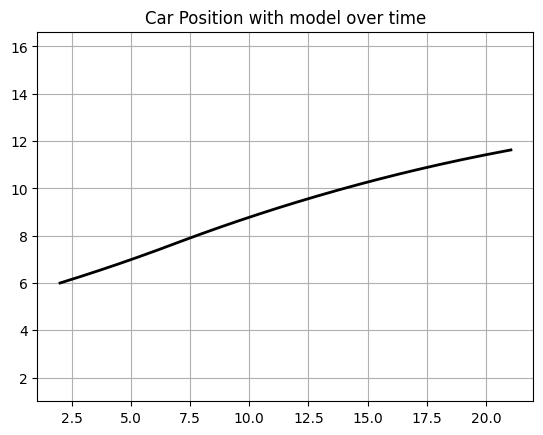

Model state Function: 


Matrix([
[      dt*v*cos(theta) + x],
[      dt*v*sin(theta) + y],
[                 a*dt + v],
[theta + dt*v*tan(delta)/L]])

Model Jacobian


Matrix([
[1, 0,   dt*cos(theta), -dt*v*sin(theta)],
[0, 1,   dt*sin(theta),  dt*v*cos(theta)],
[0, 0,               1,                0],
[0, 0, dt*tan(delta)/L,                1]])

In [4]:
import matplotlib.pyplot as plt

class BycicleModel():
    """
    Represents a bycicle model.

    Attributes:
        x (Symbol): x coordinate.
        y (Symbol): y coordinate.
        v (Symbol): velocity.
        w (Symbol): angular velocity.
        R (Symbol): radius.
        theta (Symbol): angle.
        state (Matrix): State vector.
        Q (Matrix): Process uncertainty.
    """

    def __init__(self, L, std_accel=0.01, std_delta=0.01) -> None:
        # Model Parameters
        self.L = L
        self.std_accel = std_accel
        self.std_delta = std_delta
        # Define the symbols
        x, y, theta, v, a, delta, dt, L= symbols('x y theta v a delta dt L')
        # Define the equations
        x_plus = x + v * sympy.cos(theta)*dt
        y_plus = y + v * sympy.sin(theta)*dt
        v_plus = v + a*dt
        theta_plus = theta + v / L * sympy.tan(delta)*dt

        # Create a matrix from the equations
        self.fxu = Matrix([x_plus, y_plus, v_plus, theta_plus])

        # Calculate the Jacobian matrix
        self.F_J = self.fxu.jacobian([x, y, v, theta])
        self.V_J = self.fxu.jacobian([a, delta])        

    def predict(self, state, u, dt):
        """
        Moves the next state.

        Args:
            state (ndarray): The current state vector.
            u (ndarray): The control input vector.

        Returns:
            ndarray: The predicted state vector.
        """
        subs = self._create_subs(state, u, dt)
        x_plus = np.array(self.fxu.evalf(subs=subs)).astype(float)
        return x_plus

    def calculate_jacobian(self, state, u, dt):
        """
        Computes the Jacobian matrix.

        Args:
            x (ndarray): The state vector.

        Returns:
            ndarray: The Jacobian matrix.
        """
        subs = self._create_subs(state, u, dt)
        F_J = np.array(self.F_J.evalf(subs=subs)).astype(float)
        return F_J

    def Q(self, state, u, dt):
        """
        Calculates the process uncertainty.

        Args:
            state (ndarray): The state vector.
            u (ndarray): The control input vector.

        Returns:
            ndarray: The process uncertainty matrix.
        """

        subs = self._create_subs(state, u, dt)
        V_J = np.array(self.V_J.evalf(subs=subs)).astype(float)
        M = np.diag([self.std_accel, self.std_delta])**2

        return V_J @ M @ V_J.T
    
    def _create_subs(self, state, u, dt):
        if isinstance(state, np.ndarray):
            state = state.flatten()
        subs = {
            'x':state[0],
            'y':state[1],
            'v':state[2],
            'theta':state[3],
            'a':u[0],
            'delta':u[1],
            'dt': dt,
            'L': self.L
        }
        return subs

# sim parameters
dt = 0.1 # s
N = 200 # Steps

# state
x = 2 # m
y = 6 # m
v = 0 # m/s
theta = 0.3 # m

state = np.array([x,y,v,theta])

# control
a = 0.1 # m/s^2
delta = 2 # degree
delta = delta * np.pi/180 # radian
delta_after = -delta # radian
time_delta_change = 10 # change steering at 10 seconds

u = [a, delta]

# Bycicle model parameters
L = 2.9
std_accel = 0.1
std_delta = 1*np.pi/180

# Create an instance of the BycicleModel class
model = BycicleModel(2.9, std_accel=std_accel, std_delta=std_delta)

# Calculate Linearization over state
F_J = model.calculate_jacobian([x,y,v,theta], [a,delta], dt)

# Calculate uncertainty
Q = model.Q([x,y,v,theta], [a,delta], dt)

pos = []
# Run Kalman Filter:
for i in range(N):
    if i*dt > time_delta_change:
        u[1] = delta_after
    state = model.predict(state, u, dt)
    pos.append(state.flatten())

pos = np.array(pos)
plt.figure()
plt.plot(pos[:, 0], pos[:,1], color='k', lw=2)
plt.axis('equal')
plt.title("Car Position with model over time")
plt.grid()
plt.show()

print("Model state Function: ")
display(model.fxu)

print("Model Jacobian")
display(model.F_J)



##### Measurement Model Class

The car has a radar that provides a noisy bearing and range measurement to multiple known locations in the landscape. The measurement model must convert the state $\begin{bmatrix}x & y&\theta\end{bmatrix}^\mathsf T$ into a range and bearing to the landmark. If $\mathbf p$ 
is the position of a landmark, the range $r$ is

$$r = \sqrt{(p_x - x)^2 + (p_y - y)^2}$$

The sensor provides bearing relative to the orientation of the robot, so we must subtract the robot's orientation from the bearing to get the sensor reading, like so:

$$\phi = \arctan(\frac{p_y - y}{p_x - x}) - \theta$$


Thus our measurement model $h$ is


$$\begin{aligned}
\mathbf z& = h(\bar{\mathbf x}, \mathbf p) &+ \mathcal{N}(0, R)\\
&= \begin{bmatrix}
\sqrt{(p_x - x)^2 + (p_y - y)^2} \\
\arctan(\frac{p_y - y}{p_x - x}) - \theta 
\end{bmatrix} &+ \mathcal{N}(0, R)
\end{aligned}$$

This is clearly nonlinear, so we need linearize $h$  at $\mathbf x$ by taking its Jacobian. We compute that with SymPy below.

In [5]:
x,y, theta,v, px, py = symbols('x,y,theta, v, p_x, p_y')

z = Matrix([[sympy.sqrt((px-x)**2 + (py-y)**2)],
            [sympy.atan2(py-y, px-x) - theta]])
z.jacobian(Matrix([x, y, v, theta]))

Matrix([
[(-p_x + x)/sqrt((p_x - x)**2 + (p_y - y)**2), (-p_y + y)/sqrt((p_x - x)**2 + (p_y - y)**2), 0,  0],
[   -(-p_y + y)/((p_x - x)**2 + (p_y - y)**2),     -(p_x - x)/((p_x - x)**2 + (p_y - y)**2), 0, -1]])

It is reasonable to assume that the noise of the range and bearing measurements are independent, hence

$$\mathbf R=\begin{bmatrix}\sigma_{range}^2 & 0 \\ 0 & \sigma_{bearing}^2\end{bmatrix}$$

In [6]:
class Radar:
    def __init__(self, std_range = 0, std_bearing = 0) -> None:
        self.std_range = std_range
        self.std_bearing = std_bearing

        # Define the symbols
        x,y, theta, v, px, py = symbols('x y theta v p_x p_y')
        # Define the equations
        r = sympy.sqrt((px-x)**2 + (py-y)**2)
        bearing = sympy.atan2(py-y, px-x) - theta
        
        # Create a matrix from the equations
        self._hx = Matrix([r, bearing])

        # Calculate the Jacobian matrix
        self.H_J = self._hx.jacobian([x, y, v, theta])
    
    def calculate_jacobian(self, state, landmark):
        """
        Computes the Jacobian matrix.

        Args:
            x (ndarray): The state vector.

        Returns:
            ndarray: The Jacobian matrix.
        """
        subs = self._create_subs(state, landmark)
        H_J = np.array(self.H_J.evalf(subs=subs)).astype(float)
        return H_J

    def hx(self, state, landmark):
        """
        Predicts the measurement that the radar should have
        given.

        Args:
            x (ndarray): The state vector.

        Returns:
            ndarray: The Jacobian matrix.
        """
        subs = self._create_subs(state, landmark)
        z_pred = np.array(self._hx.evalf(subs=subs)).astype(float)
        return z_pred

    def R(self):
        return np.diag([self.std_range, self.std_bearing])

    def _create_subs(self, state, landmark):
        subs = {
            'x':state[0],
            'y':state[1],
            'theta':state[3],
            'p_x': landmark[0],
            'p_y': landmark[1]
        }
        return subs
    
    def sim_measurement(self, state, landmark):
        """
        Simulates a measurement of a landmark.

        Args:
            state (ndarray): The car's position.
            landmark (ndarray): The landmark's position.
            std_range (float): The standard deviation of the range measurement.
            std_bearing(float): The standard deviation of the bearing measurement.

        Returns:
            ndarray: The range and bearing measurements.
        """
        if isinstance(state, np.ndarray):
            state = state.flatten()
            
        dx = landmark[0] - state[0]
        dy = landmark[1] - state[1]
        theta = state[3]
        r = np.sqrt(dx**2 + dy**2) + np.random.randn() * self.std_range
        bearing = np.arctan2(dy, dx) - theta + np.random.randn() * self.std_bearing
        return np.array([[r], [bearing]])

# parameters
landmark = [5, 10]

# state
x = 0 # m
y = 0 # m
v = 2 # m/s
theta = 0 # degree

# Radar parameter
std_range=0.3
std_bearing=0.1

# Create Radar Sensor
radar = Radar(std_range=std_range, std_bearing=std_bearing)

# Simulate measurement
z = radar.sim_measurement(np.array([[x],[y],[v],[theta]]), landmark)
print(f"measurement: {z.flatten()}")
print(z.shape)
# Predict measurement
z_pred = radar.hx([x,y,v,theta], landmark)
print(f"predicted measurement: {z_pred.flatten()}")

# Calculate Jacobian
H_J = radar.calculate_jacobian([x,y,v,theta], landmark)
print("Jacobian:")
display(Matrix(H_J))

measurement: [11.45165848  1.09896929]
(2, 1)
predicted measurement: [11.18033989  1.10714872]
Jacobian:


Matrix([
[-0.447213595499958, -0.894427190999916, 0,    0],
[              0.08,              -0.04, 0, -1.0]])

##### Extended Kalman Filter

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
final EKF state: [26.93971894 13.78708628  2.37681286  0.16564378]
Final P: [0.04300289 0.05048298 0.02444571 0.00084089]


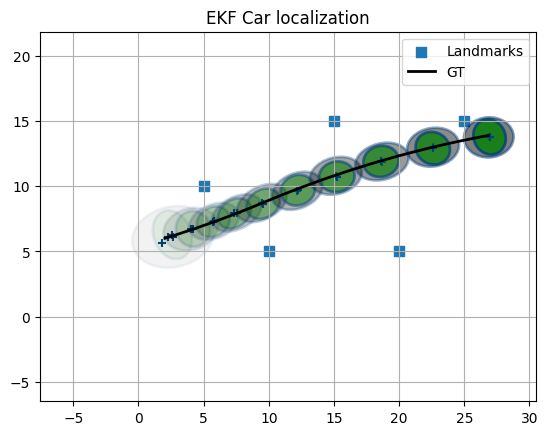

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import tools.plot_tools as plot_tools
np.random.seed(0)

class ExtendedKalmanFilter():
    """
    Represents an Extended Kalman Filter.

    Args:
        dim_x (int): Dimension of the state vector.
        dim_z (int): Dimension of the measurement vector.
        dim_u (int, optional): Dimension of the control input vector. Defaults to 0.

    Attributes:
        x (ndarray): State vector.
        dim_x (int): Dimension of the state vector.
        dim_z (int): Dimension of the measurement vector.
        P (ndarray): Uncertainty covariance.
        B (float or ndarray): Control transition matrix.
        F (ndarray): State transition matrix.
        R (ndarray): State uncertainty.
        Q (ndarray): Process uncertainty.
        y (ndarray): Residual.
    """

    def __init__(self, dim_x, dim_z, dim_u=0) -> None:
        self.x = None
        self.dim_x = dim_x
        self.dim_z = dim_z
        self.dim_u = dim_u

        self.x = np.zeros((dim_x, 1)) # state
        self.P = np.eye(dim_x)        # uncertainty covariance
        self.B = 0                    # control transition matrix
        self.R = np.eye(dim_z)        # state uncertainty
        self.gamma = np.zeros((dim_z, 1)) # residual

    def predict(self, x, model, u=0, dt = 1):
        """
        Predicts the state and covariance matrix of the extended Kalman filter.

        Args:
            x: The current state vector.
            u: The control input (default: 0).
            model: The model used for prediction (default: None).

        Returns:
            Tuple containing the predicted state vector and covariance matrix.
        """
        F_J = model.calculate_jacobian(x,u,dt)
        self.x = model.predict(x, u, dt)

        self.P = F_J @ self.P @ F_J.T + model.Q(x,u, dt)
        return self.x, self.P

    def update(self, z, sensor: Radar, args = (), hj_args = ()):
            """
            Update the state estimate based on the measurement.

            Args:
                z (numpy.ndarray): The measurement vector.
                sensor (Sensor): The sensor object used for measurement.

            Returns:
                numpy.ndarray: The updated state estimate.
                numpy.ndarray: The updated state covariance matrix.
            """
            state = self.x.flatten().copy()
            H_J = sensor.calculate_jacobian(state, *hj_args)
            self.gamma = z - sensor.hx(state, *args)
            S = H_J  @ self.P @ H_J.T + sensor.R()
            K = self.P @ H_J.T @ np.linalg.inv(S)
            self.x = self.x + K @ self.gamma
            
            self.P = (np.eye(self.dim_x) - K @ H_J) @ self.P
            return self.x, self.P

# sim parameters
dt = 1  # s
N = 200 # Steps
step = 10 # Every 'step' steps apply the kalman filter
ellipse_step = 20 # Every 'ellipse_step' plot the kalman filter

landmarks = np.array([[5, 10], 
             [10, 5], 
             [15, 15], 
             [20, 5],
             [25, 15]])

# state
x = 2 # m
y = 6 # m
v = 0.3 # m/s
theta = 0.3 # m

gt_state = np.array([x,y,v,theta])
kf_state = np.array([x,y,v,theta])

# control
a = 0.1 # m/s^2
delta = 2 # degree
delta = delta * np.pi/180 # radian
delta_after = -delta # radian
time_delta_change = 10 # change steering at 10 seconds

std_accel = 0.01
std_delta = 1*np.pi/180
u = [a, delta]

# Bycicle model parameters
L = 2.9
std_accel = 0.1
std_delta = 1*np.pi/180

# Radar parameter
std_range=0.3
std_bearing=0.1

# EKF parameters
dim_x = 4
dim_u = 2
dim_z = 2

# Create an instance of the BycicleModel class
model = BycicleModel(L, std_accel, std_delta)

# Create an instance of the radar sensor
radar = Radar(std_range=std_range, std_bearing=std_bearing)


ekf = ExtendedKalmanFilter(dim_x, dim_z, dim_u)

# GT
gts = []

plt.figure()
plt.scatter(landmarks[:, 0], landmarks[:, 1],
                marker='s', s=60, label="Landmarks")
plt.grid()
plt.title("EKF Car localization")

# Run Kalman Filter:
for i in range(N+1):
    
    # Change steering at 10 seconds
    if i/step > time_delta_change:
         u[1] = delta_after
         
    gt_state = model.predict(gt_state, u, dt/step)
    gts.append(gt_state.flatten())

    if i % step == 0:
        kf_state, P = ekf.predict(kf_state, model, u, dt)
        
        if i % ellipse_step == 0:
                plot_tools.plot_covariance(
                    (ekf.x[0,0], ekf.x[1,0]), ekf.P[0:2, 0:2], 
                     std=6, facecolor='k', alpha=i/N*0.5)
        
        # Simulate measurement
        for landmark in landmarks:
            z = radar.sim_measurement(gt_state, landmark)
            # Update
            kf_state, P = ekf.update(z, radar, args=(landmark,), hj_args=(landmark,))
        

        if i % ellipse_step == 0:
                plot_tools.plot_covariance(
                    (ekf.x[0,0], ekf.x[1,0]), ekf.P[0:2, 0:2], 
                     std=6, facecolor='g', alpha=i/N*0.8)
                
gts = np.array(gts)
plt.plot(gts[:, 0], gts[:,1], color='k', lw=2, label="GT")
plt.legend()

print(f"final EKF state: {ekf.x.flatten()}")
print(f"Final P: {ekf.P.diagonal()}")

